<a href="https://colab.research.google.com/github/p-owens/MAI/blob/main/MAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
pip install shap

In [17]:
#allow file access
from google.colab import files

from tensorflow.keras.models import load_model

import pickle

#import shap  
import shap
shap.initjs()

import pandas as pd
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() #this was required for SHAP values
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [18]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        
        print("Training Accuracy: ", self.acc)
        
def save_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to model.json and weights to model.h5")

In [19]:
ch_names = np.arange(44).tolist()
freqs = np.arange(191.6, 195.9, 0.1).tolist()
for x in range(len(ch_names)):
  ch_names[x] = "Ch %.0f (%.1f)" % (ch_names[x], freqs[x])

In [20]:
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df0 = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
df1 = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )

In [21]:
x_values = df0.to_numpy()
y_values = df1.to_numpy()

#removing the frequency row - treating these values as labels
x_values = x_values[1::2,:]

In [22]:
#generate the test dataset
#x_rem, x_test, y_rem, y_test = skl.model_selection.train_test_split(x_values, y_values, test_size=.2, random_state=0)

#generate the validation and training datasets
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size=.2, random_state=0)#renaimed x_rem and y_rem to x_values and y_values

In [23]:
inputs = keras.layers.Input(shape=(44,))


x = Dense(1056, activation='relu')(inputs)
x = Dropout(0.45)(x) # Drop out
x = Dense(1056, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out
x = Dense(1056, activation='relu')(x)
x = Dropout(0.45)(x) # Drop out random 2% to prevent overfitting
x = Dense(528, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out
predictions = Dense(44, activation='relu')(x)



# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.SGD(lr=0.02, decay=1e-6, momentum=0.99, nesterov=True)
# opt = keras.optimizers.Adadelta()

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])


model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1056)              47520     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1056)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1056)              1116192   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1056)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1056)              1116192   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1056)              0   

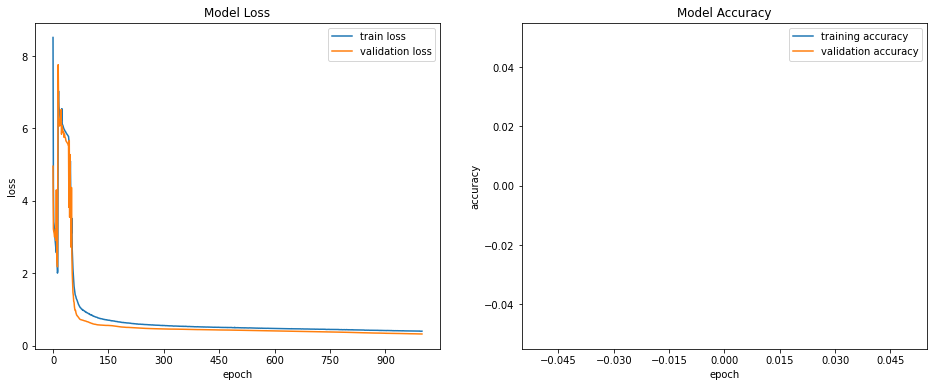

Training Accuracy:  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, N

In [24]:
pltCallBack = PlotLossAccuracy()

# and train
model.fit(x_train, y_train,
                    batch_size=4096, epochs=1000, 
                    validation_data=(x_val, y_val), 
                    callbacks=[pltCallBack])


#callbacks=[pltCallBack]          

In [30]:
#Using a dataset with 1 ch constantly on for the test set
#retreiving both datasets from GitHub

#set the channel number here
channel = 40


git_xval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/x_val.csv'.format(channel))
git_yval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/y_val.csv'.format(channel))
dfx = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
dfy = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )
x_test = dfx.to_numpy()
y_test = dfy.to_numpy()

#removing the frequency row - treating these values as labels
x_test = x_test[1::2,:]

In [ ]:
#evaluate the model on the test set
results = model.evaluate(x_test,y_test, verbose=1)
print(model.metrics_names[0] + " : " + str(results[0]) + "\n" + model.metrics_names[1] + " : " + str(results[1]))

In [ ]:
#Save model file
name = 'model_ls_%.2f_mse_%.2f.h' % (results[1], results[0])
model.save(name)
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#Generate the SHAP values for the model
background = x_train[np.random.choice(x_train.shape[0], 4999, replace=False)]
explain = shap.DeepExplainer(model, background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [ ]:
#Loading the shap model/model evaluated on the test set
pickle_off = open ('shap_vals_20_test_full.txt', "rb")
rec = pickle.load(pickle_off)
#shap.summary_plot(rec[12], x_test[0:500], sort=True, feature_names=ch_names) # , plot_type="bar")

In [ ]:
#~45 mins to evaluate, ~2300 vals
#~15 mins to evaluate, 500 vals
shap_values = explain.shap_values(x_test)

In [ ]:
#shap_values[0].shape
print(x_test[190,20])
print(y_test[190,20])
print(explain.expected_value[20])

1.0
1.984910163106256
1.3537375


In [ ]:
shap.force_plot(explain.¸¸[20], shap_values[20][190,:], x_test[0,:], matplotlib=True, feature_names=ch_names)

In [ ]:
#saving the shap model evaluated on the test set
filename = 'shap_vals_ch{0}.txt'.format(channel)

with open(('{0}'.format(filename)), 'wb') as fv:
   pickle.dump(shap_values, fv)

files.download(('{0}'.format(filename)))


#saving the shap model itself
with open('shap_model.txt', 'wb') as fm:
   explain.save(fm)

files.download('shap_model.txt')

#saving the test valeus 
with open ('test_values.txt','wb') as tv:
    pickle.dump(x_test, tv)

files.download('test_values.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
#Load a previously saved model 
model_name = 'shap_vals_ch40.txt'
pickle_off = open (model_name, "rb")
shap_values = pickle.load(pickle_off)



#Load model values
pickle_off = open ("test_values.txt", "rb")
test_values = pickle.load(pickle_off)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

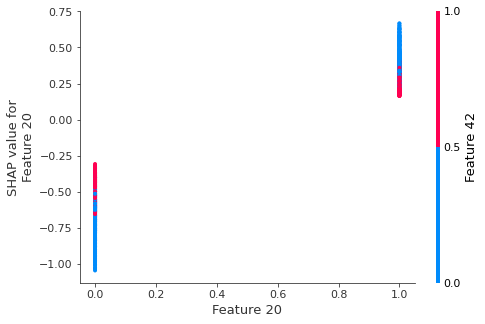

In [ ]:
chnl = 20
shap.dependence_plot(chnl, rec[chnl], x_test)

In [70]:
#computing the shap values for the effect that all the other channels have on channel 40 (in this case) 
sv_cpy = shap_values.copy()
sv_cpy[channel][:,40] = 0
avg_vec = np.average(np.absolute(sv_cpy[channel]),0)

7.6307936


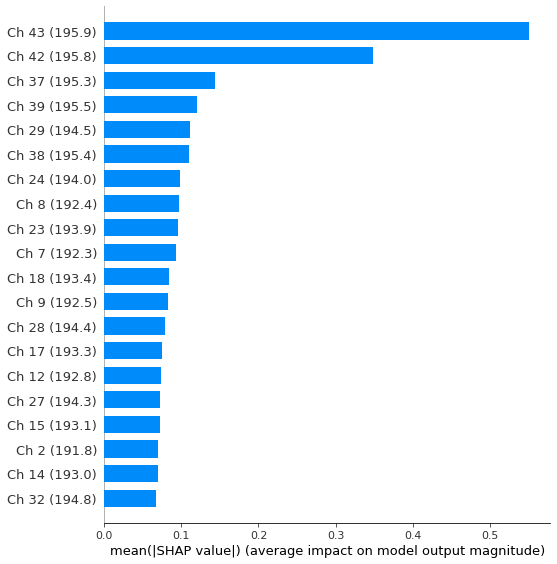

In [50]:
ch = channel
print(explain.expected_value[ch])
shap.summary_plot(sv_cpy[ch], x_test, sort=True, feature_names=ch_names, plot_type="bar")

7.6307936


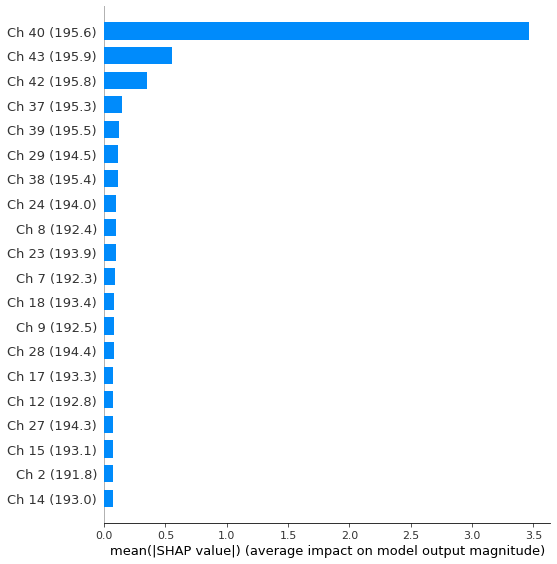

In [47]:
ch = channel
print(explain.expected_value[ch])
shap.summary_plot(shap_values[ch], x_test, sort=True, feature_names=ch_names , plot_type="bar")

In [ ]:
explain.expected_value

array([0.9534942 , 0.        , 0.7927462 , 0.8518506 , 0.92331034,
       1.3246907 , 0.        , 1.0107468 , 1.0251724 , 1.0208068 ,
       1.3949221 , 0.        , 0.95249236, 0.9051791 , 0.91201836,
       1.2035263 , 0.        , 0.87858206, 0.9007439 , 0.88924885,
       1.3537375 , 0.        , 1.0805315 , 1.0956192 , 1.1726921 ,
       1.5955248 , 0.        , 1.1587155 , 1.1125916 , 1.0832379 ,
       1.3773067 , 0.        , 1.0073377 , 1.0780278 , 1.1074249 ,
       2.091779  , 0.        , 2.0856688 , 2.7254815 , 3.7202327 ,
       7.6247334 , 0.        , 7.1145854 , 7.7517705 ], dtype=float32)

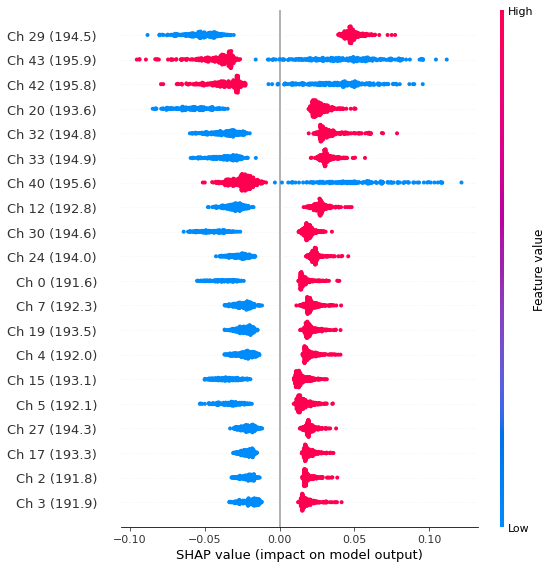

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

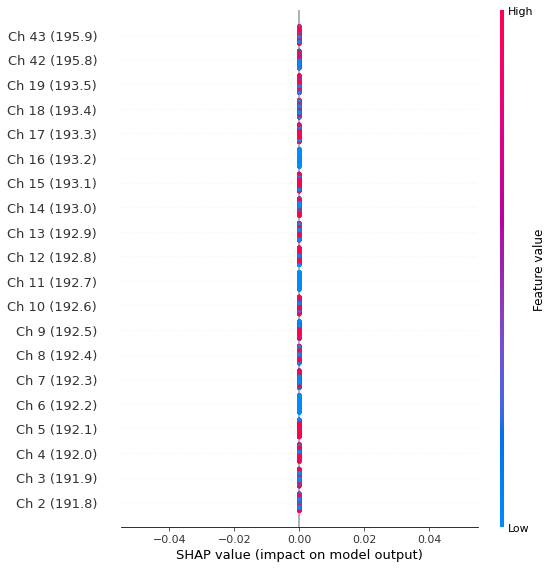

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

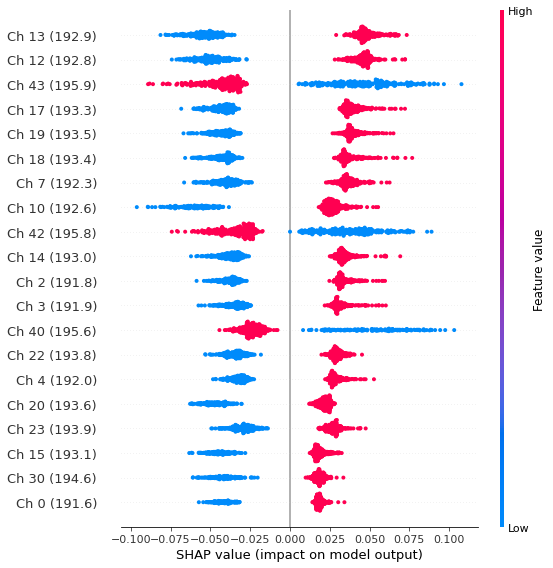

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

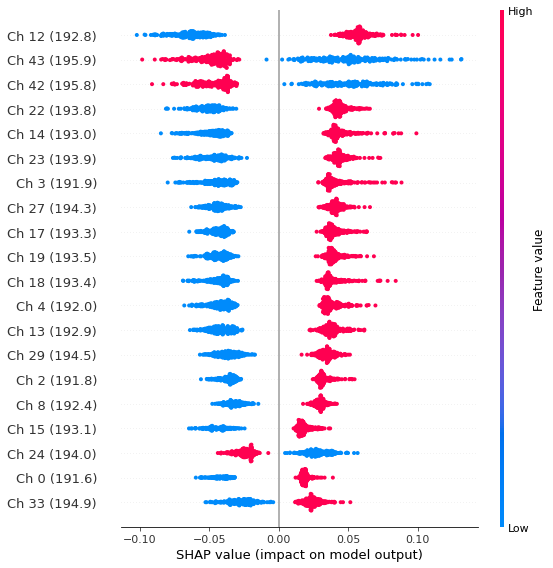

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

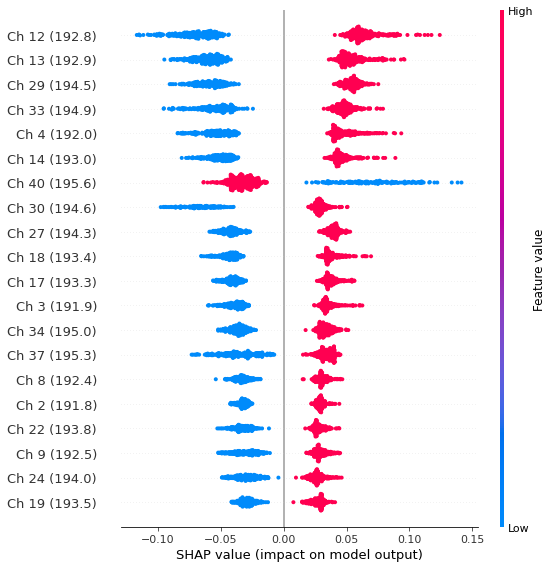

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

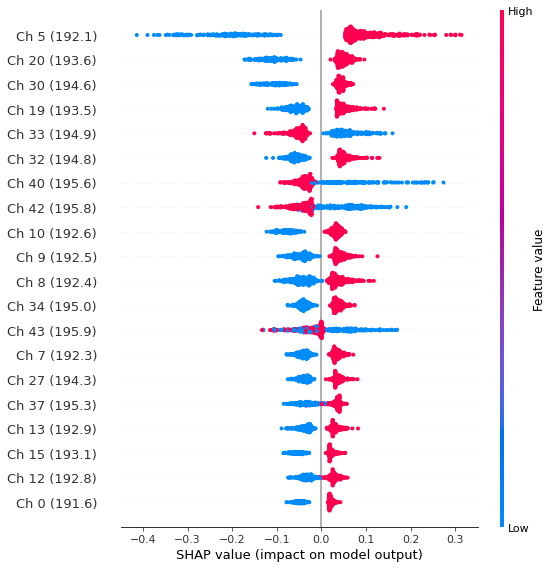

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

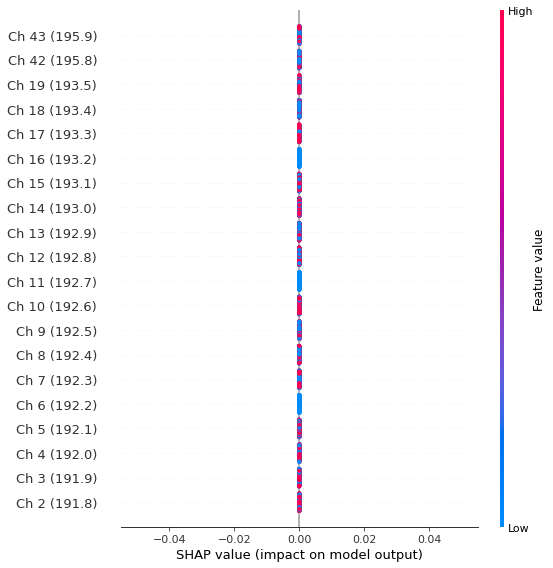

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

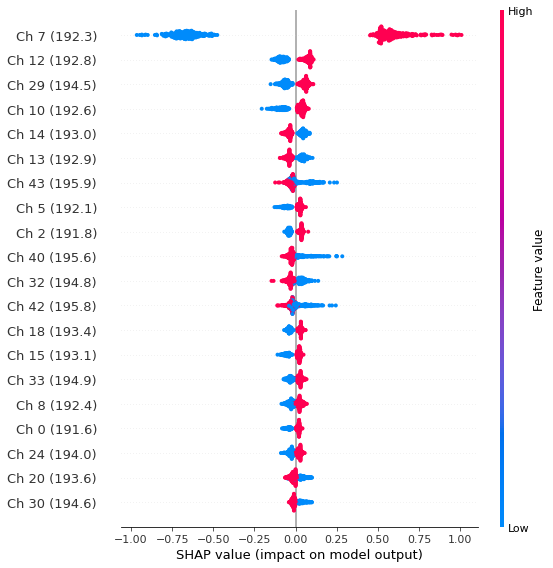

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

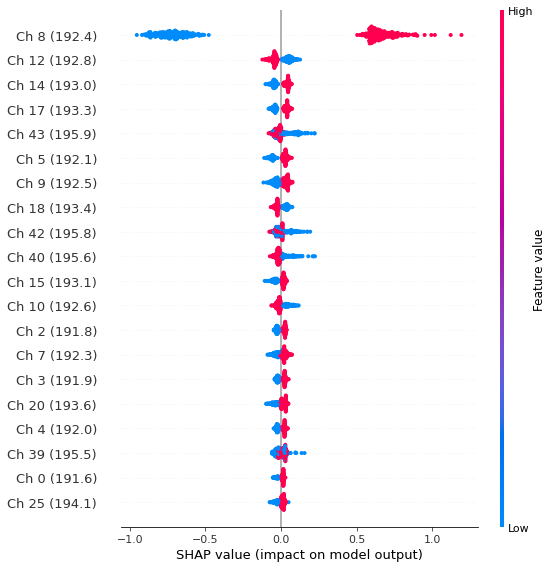

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

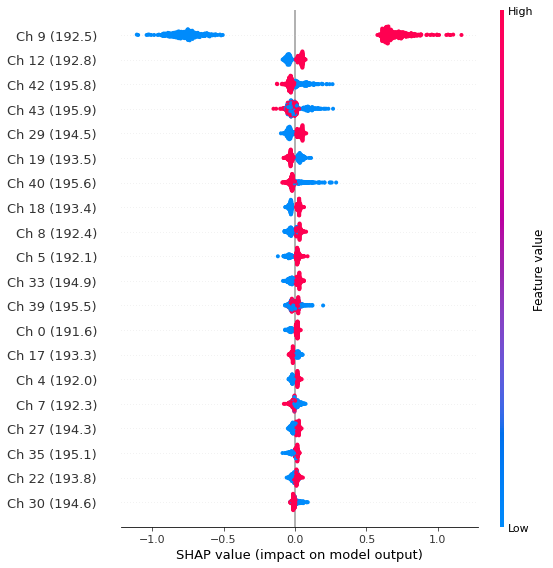

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

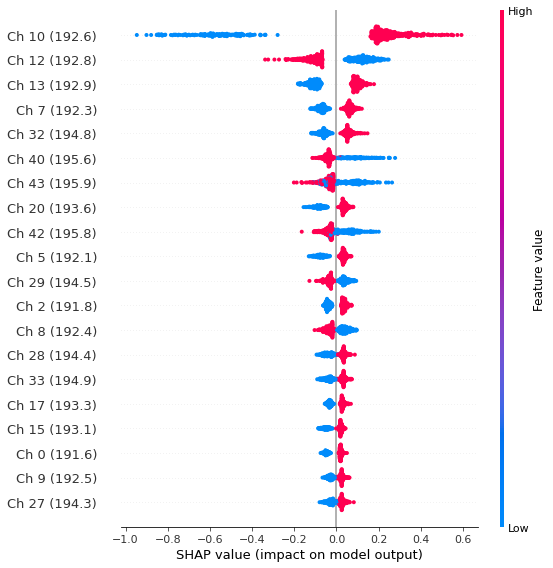

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

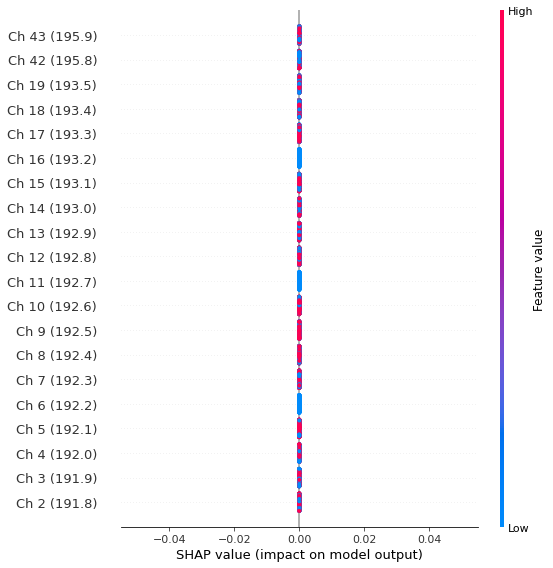

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

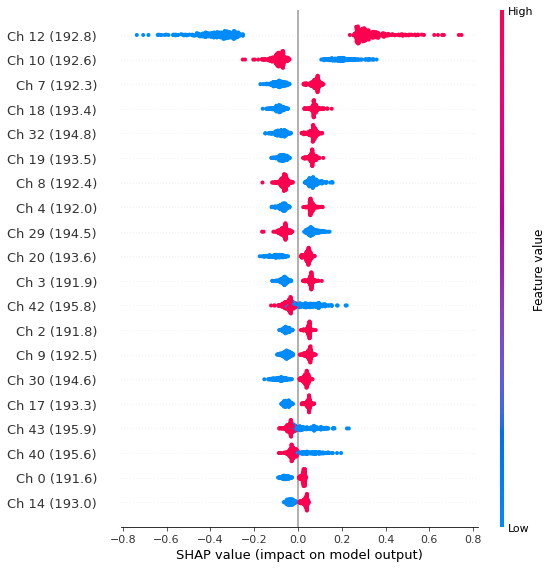

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

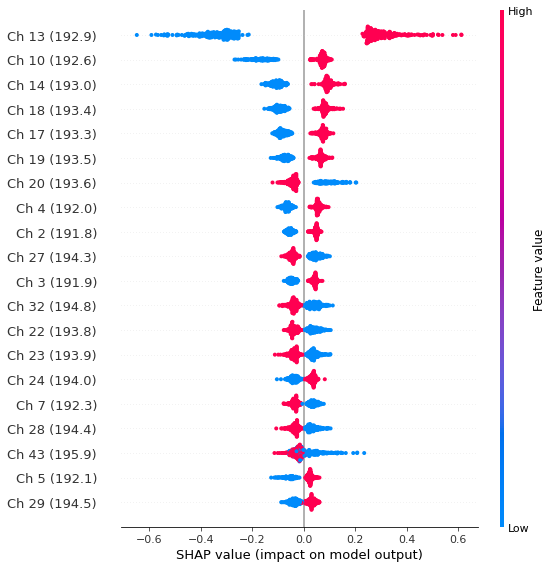

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

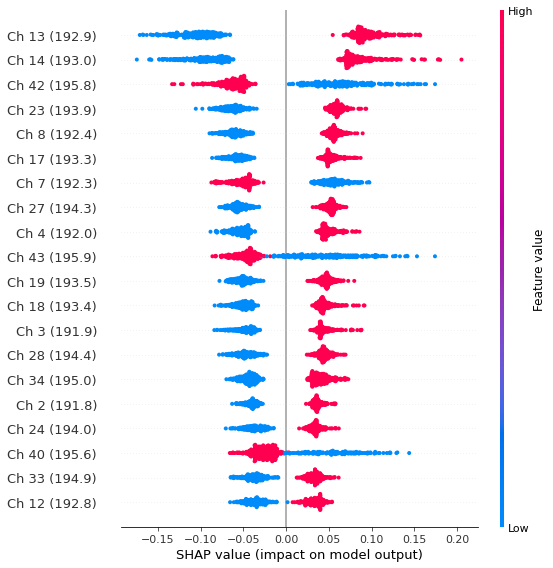

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

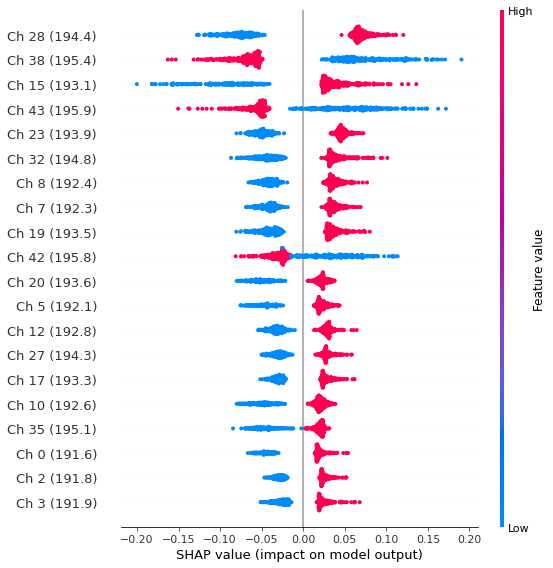

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

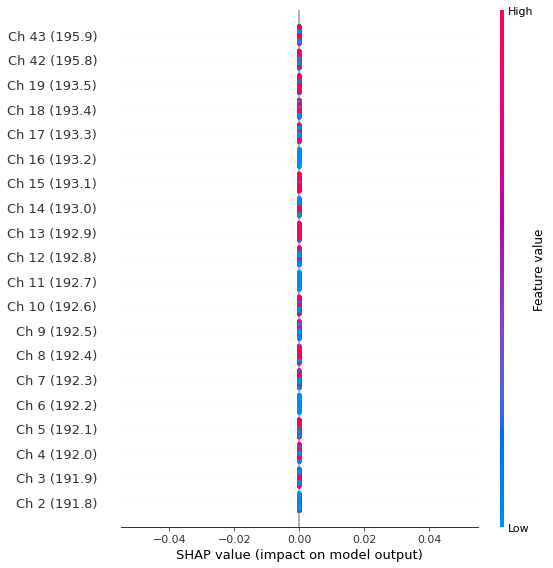

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

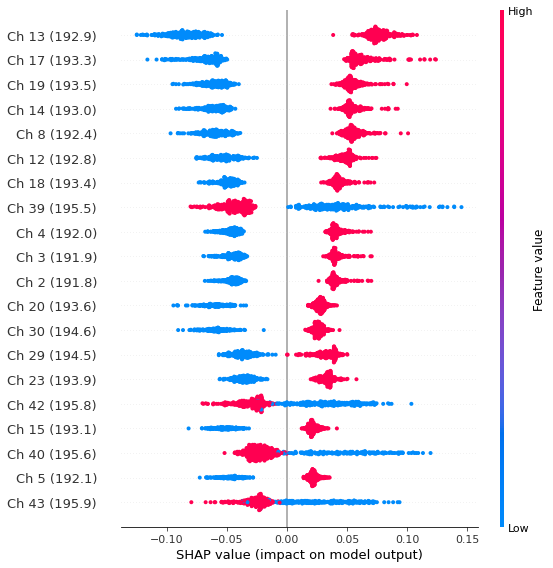

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

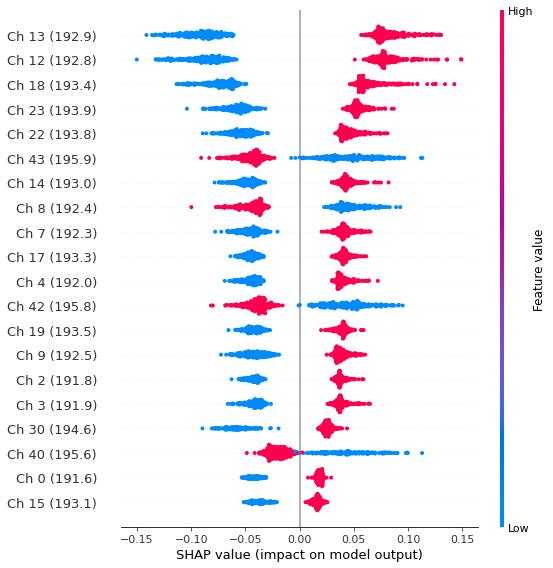

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

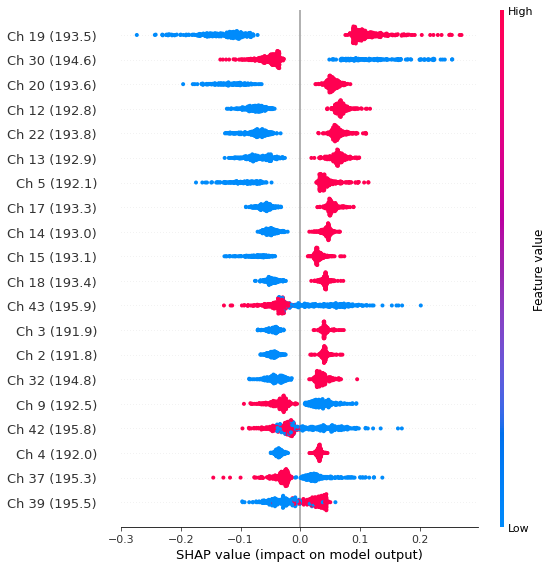

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

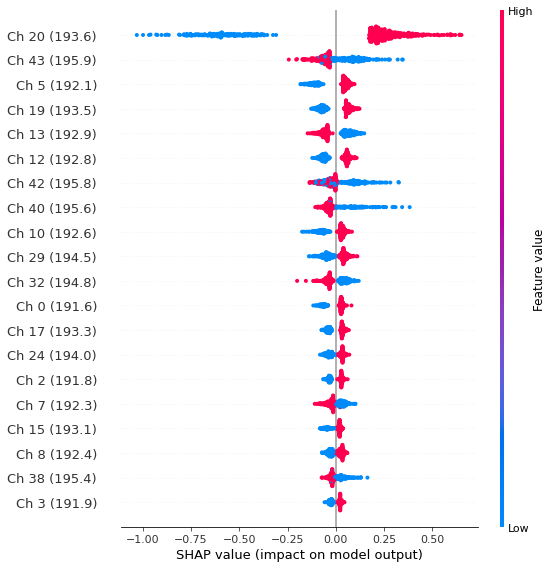

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

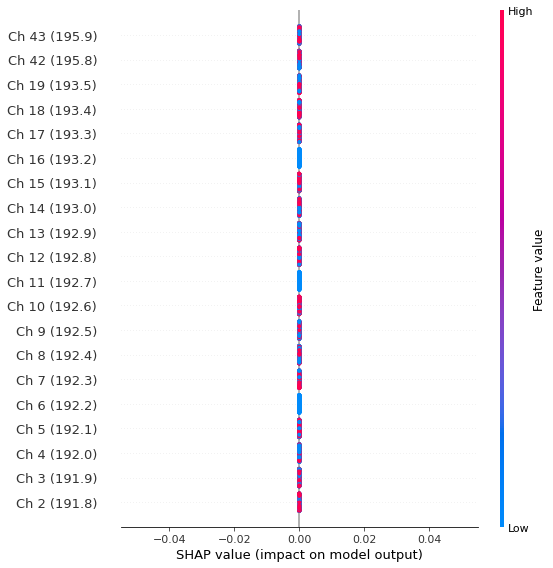

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

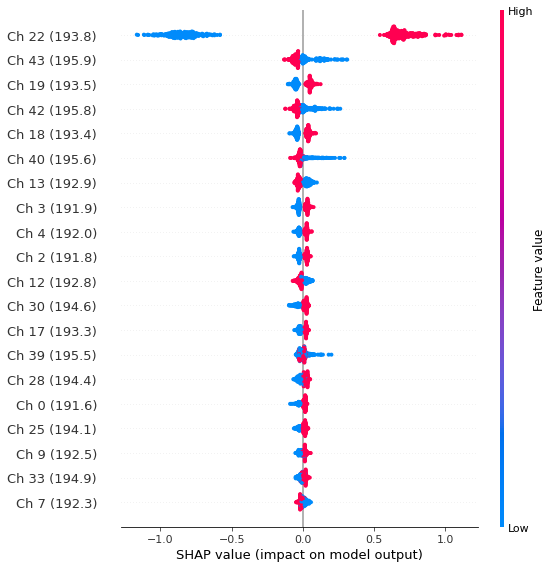

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

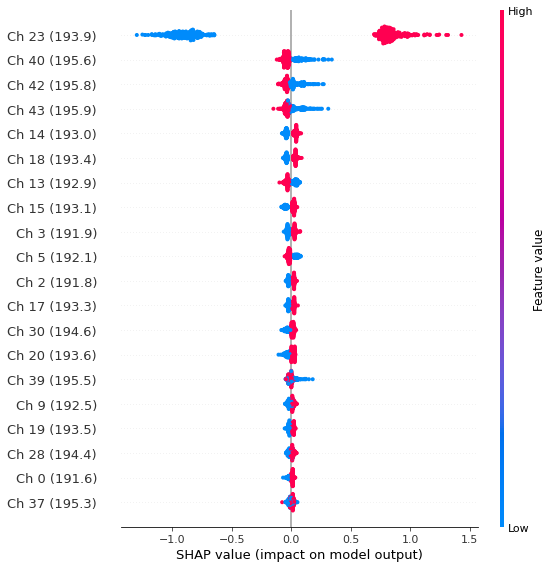

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

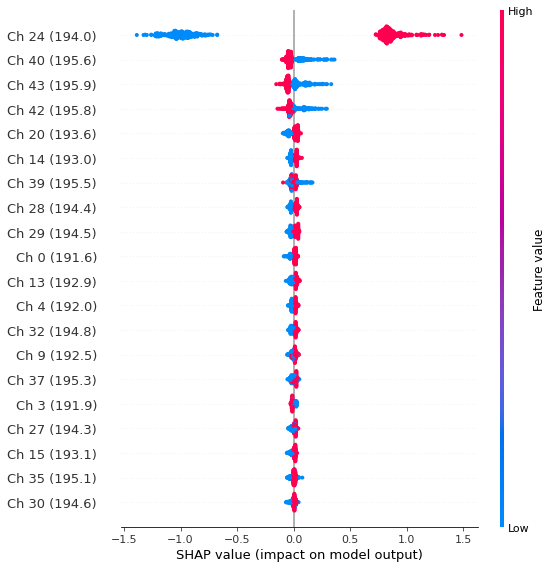

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

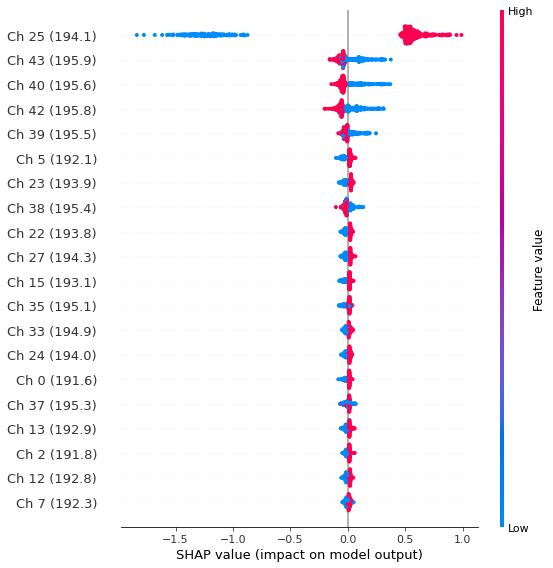

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

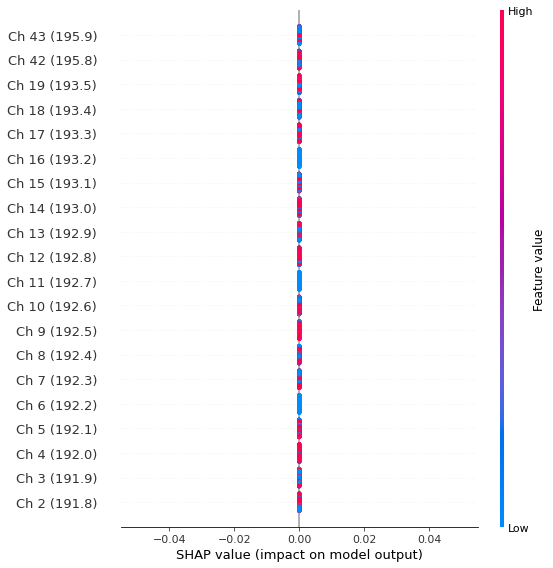

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

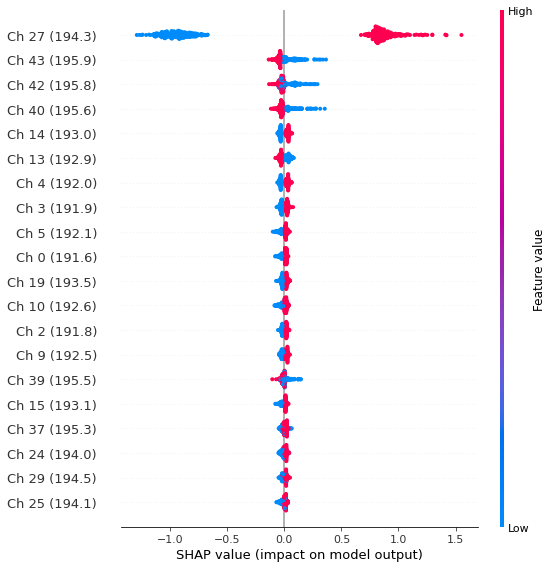

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

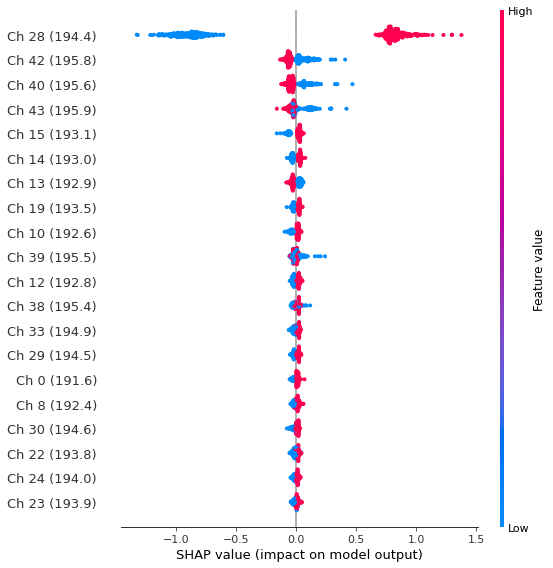

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

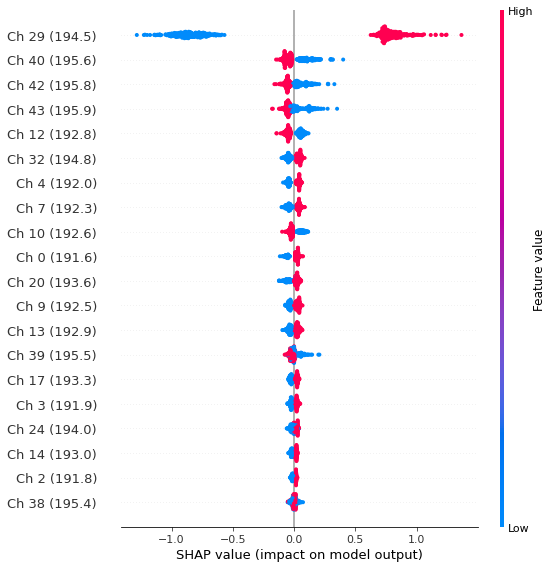

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

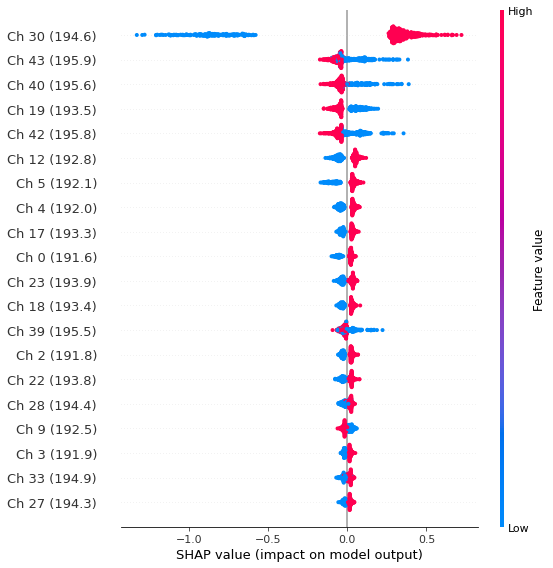

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

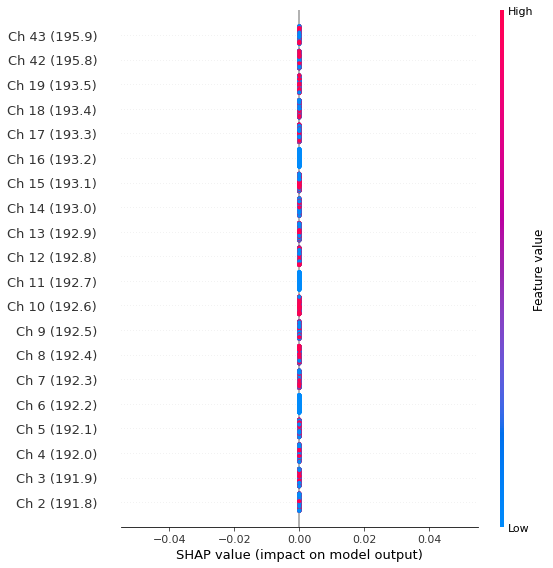

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

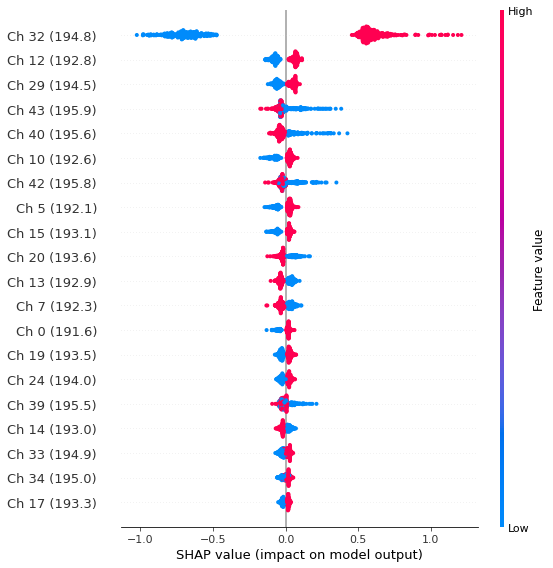

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

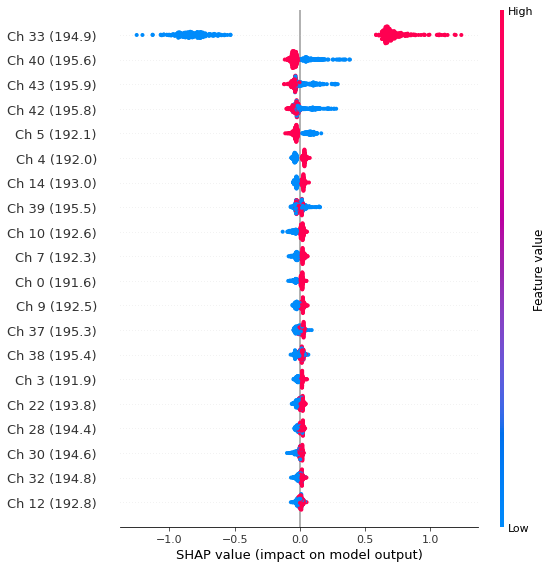

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

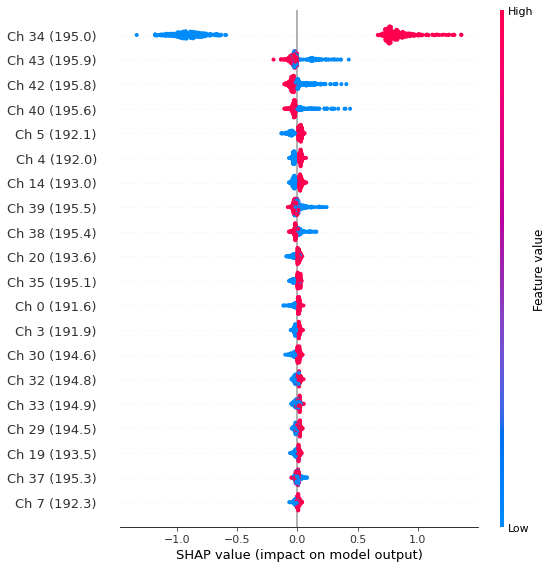

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

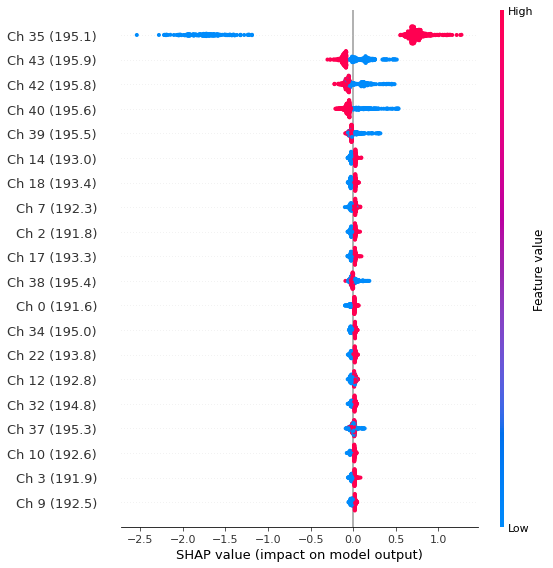

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

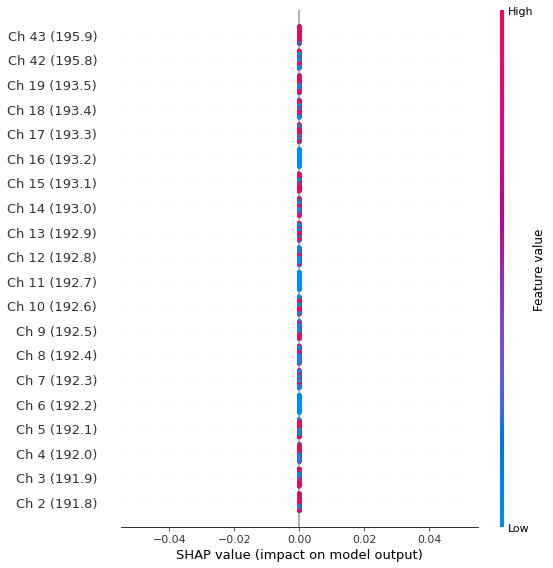

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

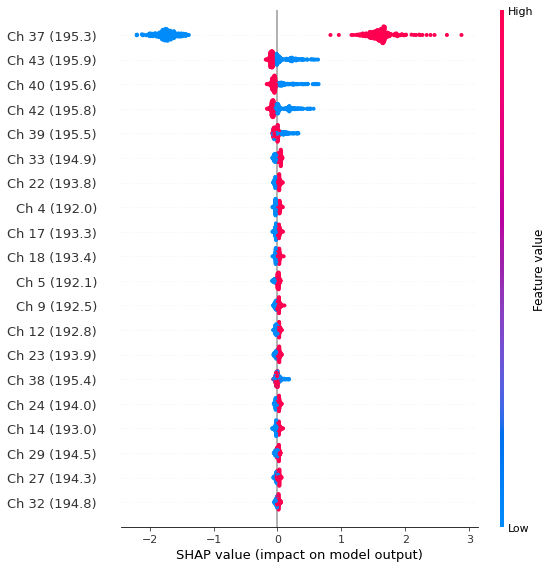

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

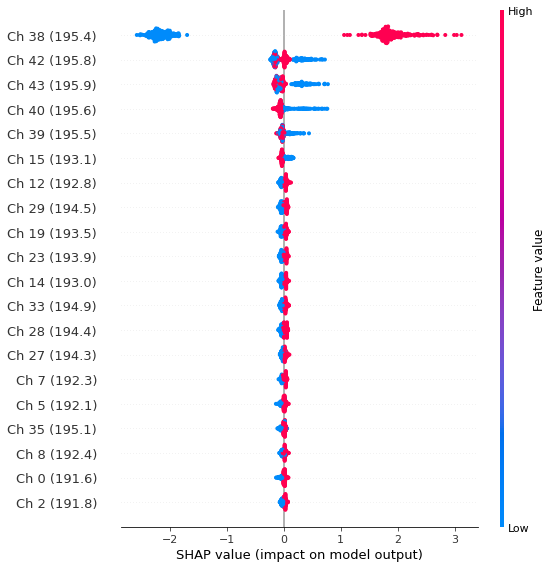

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

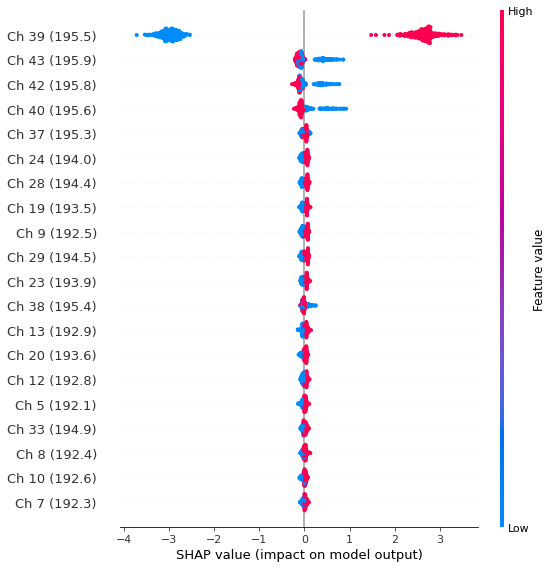

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

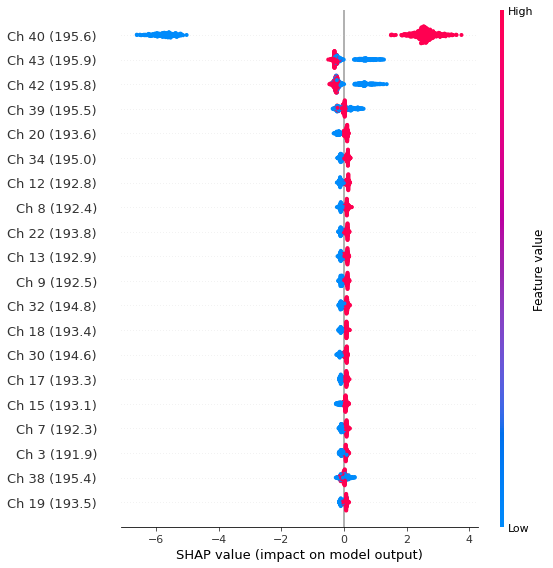

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

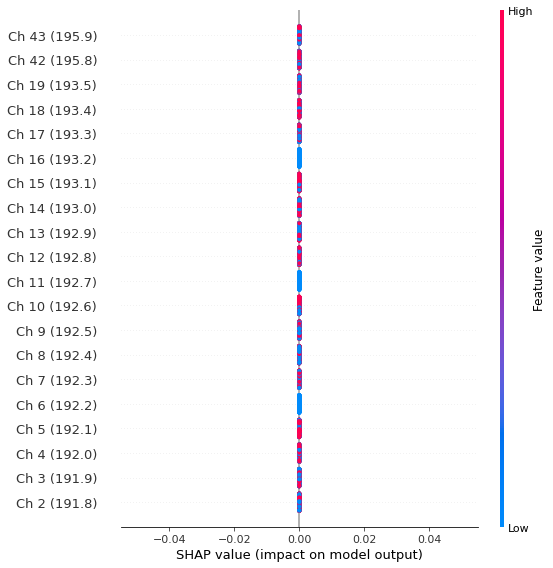

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

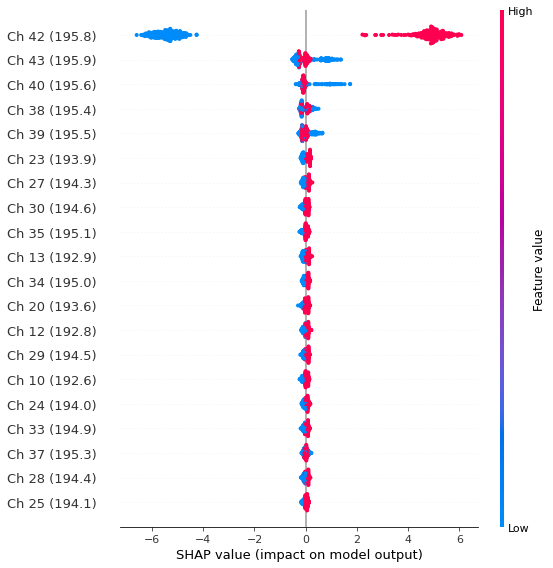

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

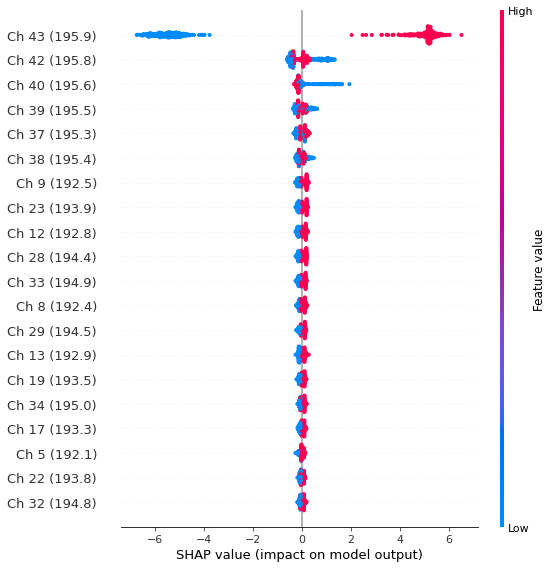

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
for ch in range(len(shap_values)):
  #print(x_test[ch].mean())
  name = 'shap_plot_ch_%.0f' % ch
  fig = shap.summary_plot(shap_values[ch], x_test[0:500], sort=True, feature_names=ch_names, title=name) # , plot_type="bar")
  f_name = name + '.png'
  plt.savefig(f_name)
  files.download(f_name)


In [ ]:
#choose a few random examples from the dataset
x_samp = x_test.copy()
rng_choice = np.arange(0, x_test.shape[0], 75)
samp = x_samp[rng_choice] 
print(samp)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 1. ... 0. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 1.]]


In [ ]:
# Write in a function
def shap_plot(j):
    shap_values_Model = explain.shap_values(samples)
    p = shap.force_plot(explain.expected_value[j], shap_values_Model[j], samples[j])
    return(p)

shap_plot(0)

In [ ]:
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
explainer = shap.explainers.Permutation(model, background)

In [ ]:
shap_values = explainer(x_test[0:5])

In [ ]:
shap.summary_plot(shap_values, x_test[1:5], ch_names, 44)